Figure 3: Shock predicting cell co-firing stifled by ANI administration

In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg
from copy import copy, deepcopy
from tqdm import tqdm

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova
from stats_utils import resample, bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired
from subjects import save_df, load_df

In [2]:
def add_memory_designations(df_use, key_use="d1_d2", before=['-2_-1', '-1_4'], during=['4_1'], 
                            after=['1_2', '2_7'], designation_key='Designation'):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df[key_use] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df[key_use] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df[key_use] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df[designation_key] = desig
    
    return df

[8.5 8. ]
[8.5 6.5]


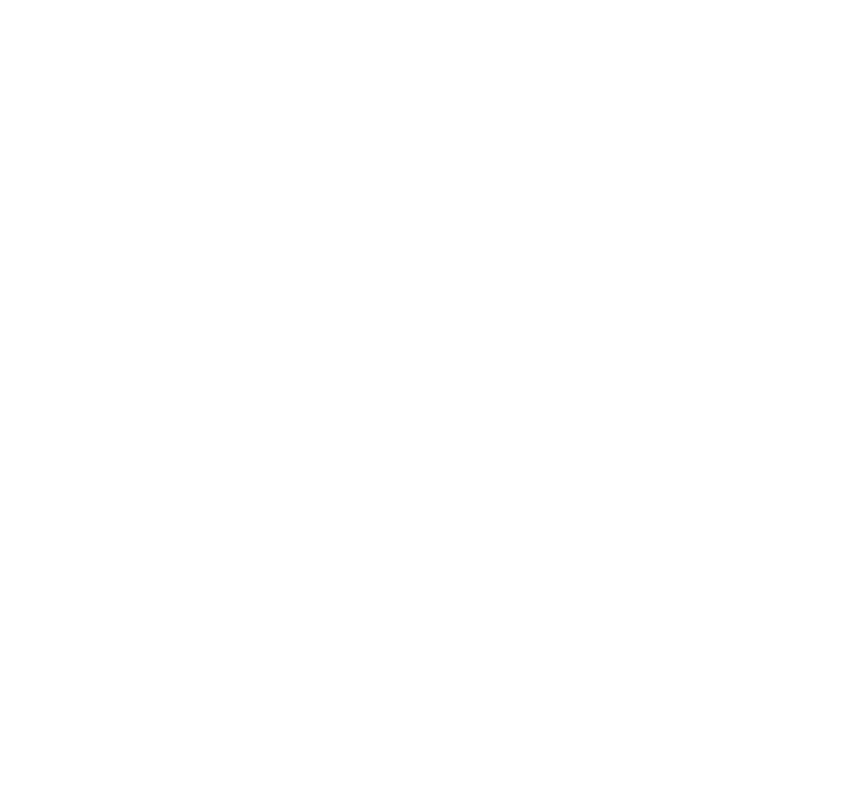

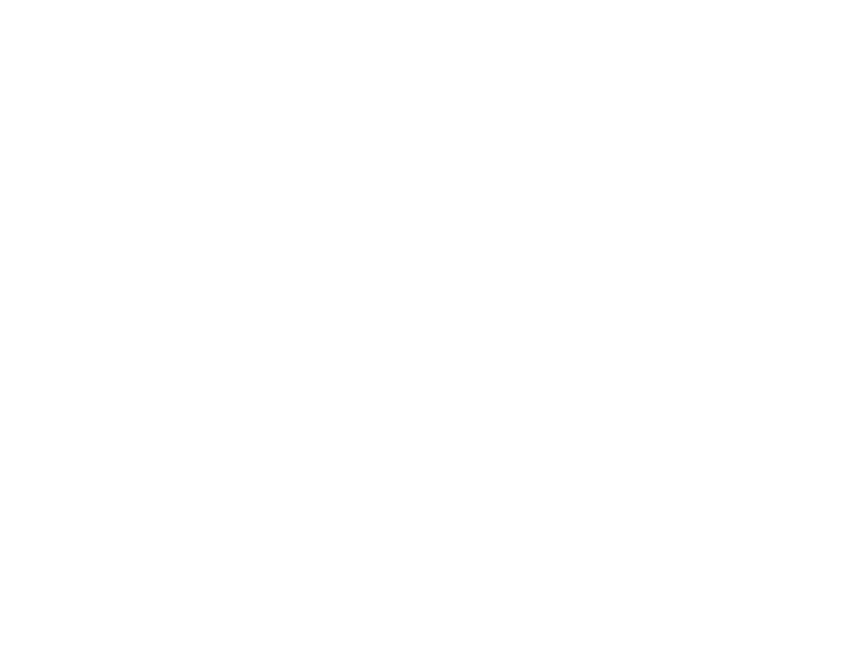

In [3]:
%matplotlib ipympl
Fig3 = Fig(num=3, grid=(5, 4), size=(8.5, 8.0), fontsize=6, constrained_layout=False)  # size=(7.2, 5.3) if not scaling properly
print(Fig3.fig.get_size_inches())
Fig3stats = Fig(num="Figure 3 stats", grid=(5, 4), size=(8.5, 6.5), fontsize=3) 
print(Fig3stats.fig.get_size_inches())
Fig3comb = FigMirror(Fig3, Fig3stats)

[8.5  8.75]
[8.5  8.75]


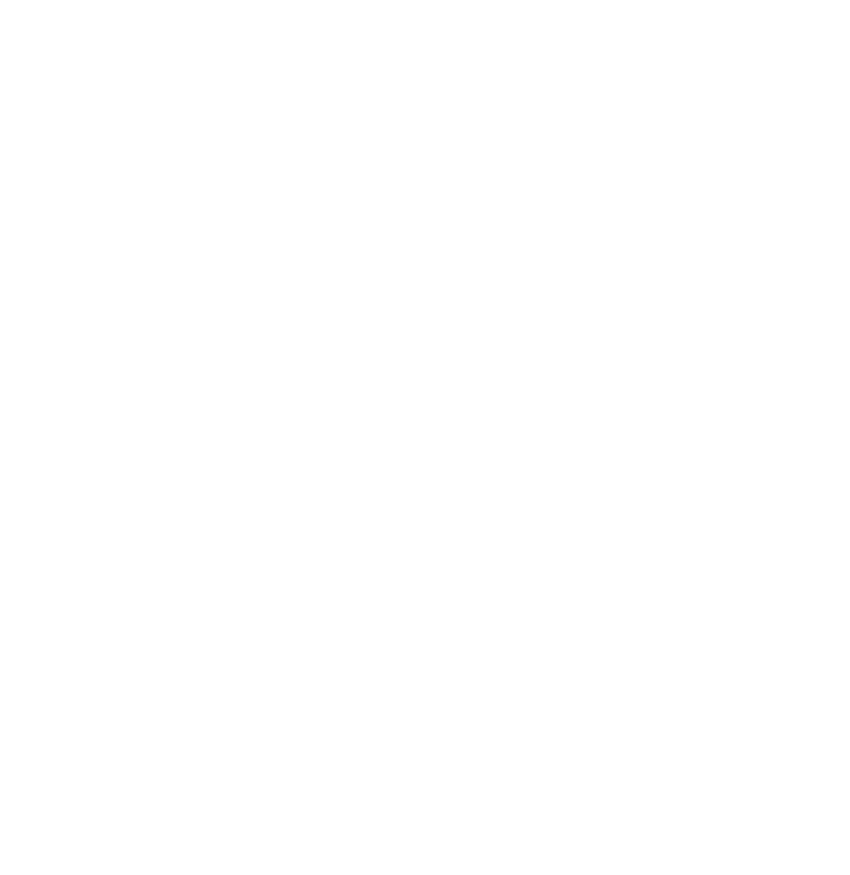

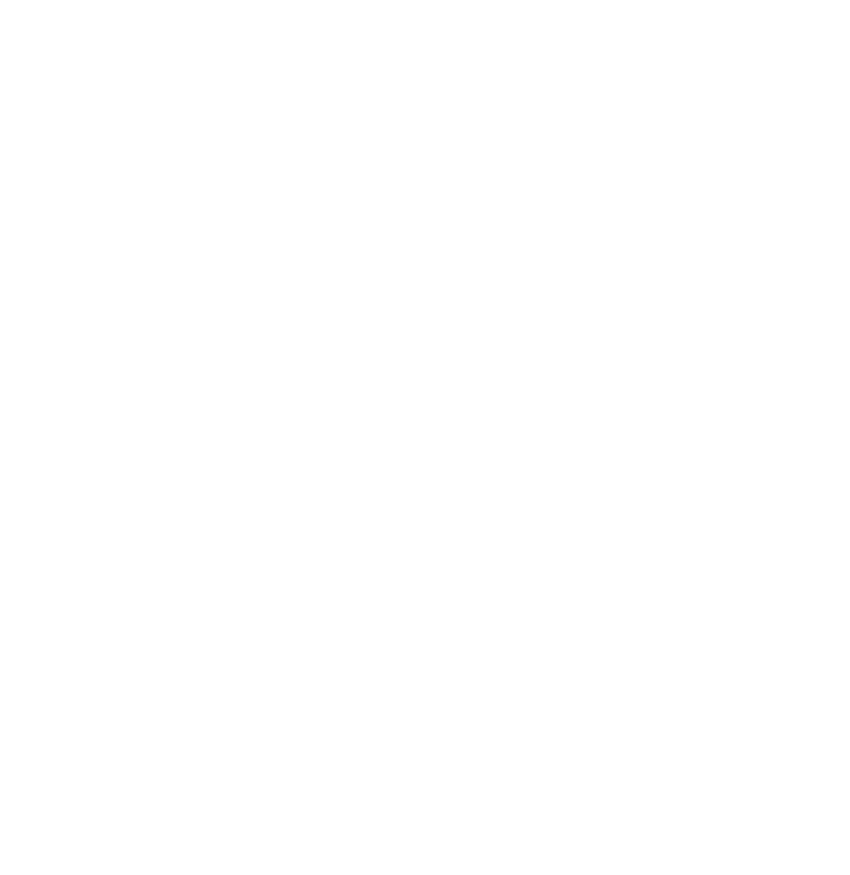

In [4]:
%matplotlib ipympl
FigS6 = Fig(num="S6", grid=(6, 4), size=(8.5, 8.75), fontsize=6)  # size=(7.2, 5.3) if not scaling properly
print(FigS6.fig.get_size_inches())
FigS6stats = Fig(num="Figure S6 stats", grid=(6, 4), size=(8.5, 8.75), fontsize=6) 
print(FigS6stats.fig.get_size_inches())
FigS6comb = FigMirror(FigS6, FigS6stats)

In [5]:
# IMPORTANT - use consistent times before/after freeze onset to find and analyze freeze predictive cells
# Note that 2 seconds before/after (buffer_sec=(2, 2)) is the default used for all calculations and .pkl files saved
# in .pkl files unless otherwise designated.
buffer_sec_use = (4, 4)  # use this to find significance
buffer_sec_plot = (4, 4)  # use this for plotting to show that the relevant window of activity is actually +/- 2 sec
# and that 2-4 sec prior activity is closer to baseline

### First, plot example freezing cells from Marble07: 53, 67, 90, and 334

In [ ]:
mmd = fa.MotionTuningMultiDay('Marble07', arena='Shock', days=[-1, 4, 1, 2], 
                              buffer_sec=buffer_sec_plot)

In [ ]:
# Example raster side-by-side for sanity check on high covariance of these two cells
_, ax = plt.subplots(1, 2)
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][334], ax=ax[0])
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][53], ax=ax[1])

### 3A: Plot example traces from freeze-tuned cells. Blue = 53, Pink = 334.

In [ ]:
# Plot example traces from freeze-tuned cells. Blue = 53, Pink = 334.
ax_ex_cell_cofire = Fig3.subplot2grid(Fig3.gs[0, 0:3], grid=(1, 2), return_axes=True)
neurons_plot = [53, 334]
im_data = sio.loadmat(mmd.motion_tuning['Shock'][1].dir_use / 'FinalOutput.mat')
rawtraces = im_data['NeuronTraces']['RawTrace'].squeeze().item()
rawtraces = rawtraces[:, :mmd.motion_tuning['Shock'][1].PSAbool.shape[1]]  # Align rawtraces with PSAbool
rawz = (rawtraces - rawtraces.mean(axis=1)[:, None])/rawtraces.std(axis=1)[:, None]
psabool = mmd.motion_tuning['Shock'][1].PSAbool
t = np.arange(0, mmd.motion_tuning['Shock'][1].PSAbool.shape[1])/mmd.motion_tuning['Shock'][1].sr_image
for ax, xlim in zip(ax_ex_cell_cofire, ([265, 290], [340, 380])):
    for psa, trace in zip(psabool[[neurons_plot]].astype(bool).squeeze(), rawz[[neurons_plot]].squeeze()):
        ax.plot(t, trace)
        for event_idx in contiguous_regions(psa):
            ax.plot(t[event_idx[0]:event_idx[1]], trace[event_idx[0]:event_idx[1]], 'r')

    for ftimes in mmd.motion_tuning['Shock'][1].freezing_times:
        ax.axvspan(ftimes[0], ftimes[1], color=[0, 1, 0, 0.3])

    ax.set_xlim(xlim)
    ax.set_frame_on(True)

In [ ]:
# Plot heatmaps as sanity check - these aren't just overlapping place cells. 
# Rather, they fire in a lot of different places
PF = pf.load_pf('Marble07', 'Shock', 1)
_, ax = plt.subplots(1, 2, figsize=(6, 3))
for a, nid in zip(ax, neurons_plot):
    sns.heatmap(PF.tmap_sm[nid], ax=a)

### 3C and S6K-L: Plot PBE examples - all cell coactivity around time of freezing

In [ ]:
# Set up PBE dataframes
buffer_plot = (4, 4)
PBElearn = cova.get_group_PBE_rasters(err.learners, 'Learners', buffer_sec=buffer_plot)
PBEnlearn = cova.get_group_PBE_rasters(err.nonlearners, 'Non-Learners', buffer_sec=buffer_plot)
PBEani = cova.get_group_PBE_rasters(err.ani_mice_good, 'ANI', buffer_sec=buffer_plot)

control_mice_good = copy(err.learners)
control_mice_good.extend(err.nonlearners)
PBEctrl = cova.get_group_PBE_rasters(control_mice_good, 'Control', buffer_sec=buffer_plot)

# Now combine and simplify data
PBEcomb, PBEcomb_simp = {}, {}
for day in [-2, -1, 4, 1, 2]:
    PBEcomb[day] = pd.concat([PBElearn[day], PBEnlearn[day], PBEani[day]])
    PBEcomb_simp[day] = pd.concat([PBEctrl[day], PBEani[day]])

# Add in memory/group designations to dataframe
PBEcomb_simp2 = add_memory_designations(pd.concat(PBEcomb_simp.values()), key_use="day",
                                       before=[-2, -1], during=[4], after=[1, 2])

In [ ]:
# Now plot PBEs
alpha = 0.05

cmap_2grps = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap
ax_pbe_bef, _ = FigS6comb.subplot(FigS6.gs[3, 2])
ax_pbe_4hr, _ = FigS6comb.subplot(FigS6.gs[3, 3])
ax_pbe_aft, _ = Fig3comb.subplot(544)

for a, desig in zip([ax_pbe_bef, ax_pbe_4hr, ax_pbe_aft], ['Before', '4hr', 'After']):
    sns.lineplot(data=PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig], palette=cmap_2grps, dashes=["", (2.5, 1)],
                                    x='times', y='act_neuron_ratio_z', hue='group', style='group', ax=a)
    
    # Get sig bins and plot
    p_t, tstat_t = [], []
    for timept in np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times']):
        time_bool = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'] == timept
        df_tpt = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig][time_bool]
        control_bool = df_tpt['group'] == 'Control'
        ani_bool = df_tpt['group'] == 'ANI'
        tstat, p = s.ttest_ind(df_tpt[control_bool]['act_neuron_ratio_z'],
                                   df_tpt[ani_bool]['act_neuron_ratio_z'])
        p_t.append(p)
        tstat_t.append(tstat)
    
    # Plot sig

    times_plot = np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'])
    sigbool = np.array(p_t) < alpha
    ylim = a.get_ylim()
    a.plot(times_plot[sigbool], np.ones(np.sum(sigbool))*ylim[1]*0.9, 'r.')
    a.set_xlabel('Time from freeze start (s)')
    a.set_ylabel(r'$Z_{nactive}$')


### 3D-F and S6A-C: example freeze tuned cells across days

In [ ]:
# Other example cell for supplemental - Non-Learner
axnonlrncell, axnonlrncell_stats = FigS6comb.subplot2grid(FigS6.gs[0, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble11', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(584, base_day=1, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                            plot_ROI=False, ax=axnonlrncell, rasterized=True)

In [ ]:
# Other example cell for supplemental - Learner
axlrncell3, axlrncell3_stats = FigS6comb.subplot2grid(FigS6.gs[1, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble24', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(36, base_day=1, base_arena='Shock', batch_map=False, 
                            smooth_sec=0.5, plot_ROI=False, ax=axlrncell3, rasterized=True)

In [ ]:
# Maybe better learner cell?
axlrncella, axlrncella_stats = Fig3comb.subplot2grid(Fig3.gs[1, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(334, base_day=1, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                            plot_ROI=False, ax=axlrncella.squeeze(), label_fig=False, rasterized=True)

In [ ]:
mmd.plot_raster_across_days(53, base_day=1, base_arena='Shock', batch_map=False,
                           plot_ROI=False, label_fig=False, rasterized=True, smooth_sec=0.5) 

In [ ]:
# Example learner cell from same sessions as first second row
axlrncellb, axlrncellb_stats = Fig3comb.subplot2grid(Fig3.gs[2, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(53, base_day=1, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                           plot_ROI=False, ax=axlrncellb.squeeze(), label_fig=False, rasterized=True) 

In [ ]:
# Example unstable ANI cell
# Need to update this to look out +/- 2 sec due to different frame rate
axanicell, axanicell_stats = Fig3comb.subplot2grid(Fig3.gs[3, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble20', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(2, base_day=4, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                           plot_ROI=False, ax=axanicell.squeeze(), label_fig=False, rasterized=True)

In [ ]:
axlrncell2, axlrncell2_stats = FigS6comb.subplot2grid(FigS6.gs[2, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble27', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(22, base_day=4, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                           plot_ROI=False, ax=axlrncell2.squeeze(), label_fig=False, rasterized=True)

### 3G: Snake plots of timing for each group

In [ ]:
# Set up subfigures for snake plots
axrow1 = Fig3comb.subplot2grid(Fig3.gs[1, 2:], grid=(1,3), return_axes=True)
ax_snake_lrn, ax_snake_nlrn, ax_snake_ani = axrow1[0]

In [ ]:
# Plot into figure
_, _, _ = fa.freeze_group_snake_plot(err.learners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=ax_snake_lrn)
_, _, _ = fa.freeze_group_snake_plot(err.nonlearners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=ax_snake_nlrn)
_, _, _ = fa.freeze_group_snake_plot(err.ani_mice_good, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=ax_snake_ani)
[a.set_title(gname) for a, gname in zip(axrow1[0], ['Learners', 'Non-Learners', 'ANI'])];
[a.set_frame_on(True) for a in axrow1[0]];

In [ ]:
# Plot here for reference
_, atemp = plt.subplots(1, 3, figsize=(10, 3))
_, _, _ = fa.freeze_group_snake_plot(err.learners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=atemp[0])
_, _, _ = fa.freeze_group_snake_plot(err.nonlearners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=atemp[1])
_, _, _ = fa.freeze_group_snake_plot(err.ani_mice_good, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=atemp[2])

### 3H: Freeze cell ECDF plots

In [ ]:
# Pre-allocate dictionary for group plots later on
rast_dict = {'Learners': {}, 'Non-Learners': {}, 'ANI': {}}
arena = 'Shock'
for group, lgroup in zip (['Learners', 'Non-Learners', 'ANI'],
                          [err.learners, err.nonlearners, err.ani_mice_good]):
    for day in [-2, -1, 4, 1, 2]:

        _, lrn_ids, times = fa.freeze_group_snake_plot(lgroup, arena, day, buffer_sec=buffer_sec_plot, plot=False)
        rast_dict[group][day] = times[lrn_ids]
    

In [ ]:
# Set up 2nd row for plotting
axrow2 = Fig3comb.subplot2grid(Fig3.gs[2, 2:], grid=(1,3), return_axes=True)
axcdf_bef, axcdf_aft = axrow2[0][0:2]
axcdf_bef_stats, axcdf_aft_stats = axrow2[1][0:2]

In [ ]:
_, axtest = plt.subplots(1, 3, figsize=(9, 3))
_, axstat_test = plt.subplots(1, 3, figsize=(9, 3))
axuse = axtest

map_use = sns.color_palette('Set2')[0:3]

for a, astat_use, day_group, sesh_time in zip(axuse, axstat_test, [[-2, -1], [4], [1, 2]], 
                                   ['Before', '4 hour', 'After']):
    means_print = []
    rast_combined = []
    ystat=1
    for group in ['Learners', 'Non-Learners', 'ANI']:
        rast_use = []
        for day in day_group:
            rast_use.append(rast_dict[group][day])
        sns.ecdfplot(np.concatenate(rast_use), ax=a, palette='Set2', hue_order=['Learners', 'Non-Learners', 'ANI'])
        means_print.append(np.mean(np.concatenate(rast_use)))
        rast_combined.append(np.concatenate(rast_use))
        astat_use.text(0.1, ystat, f'{group} wilcoxon: {pg.wilcoxon(np.concatenate(rast_use))}')
        ystat -=0.1
    
    astat_use.text(0.1, ystat, 
                   f'Lrn. v. Nlrn Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[1], alternative="less")}')
    astat_use.text(0.1, ystat - 0.1, 
                   f'Lrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[2], alternative="less")}')
    astat_use.text(0.1, ystat - 0.2, 
                   f'Nlrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[1], rast_combined[2], alternative="less")}')
    
    for line, color_use in zip(a.get_children()[0:3], map_use):
        line.set_color(color_use)
    
    print(means_print)
    tt = a.plot([-buffer_sec_plot[0], buffer_sec_plot[1]], [0, 1], 'r--')
#     a.axvline(0, linestyle='-.', color='k')
    a.legend(['Learners', 'Non-Learners', 'ANI'])
    a.set_title(sesh_time)
    a.set_frame_on(True) # Make sure axes are on

In [ ]:
# Now plot ecdfs of peak activation time for freeze-predicting cells
# Group by Before-4-After
_, (axcdf_4, axcdf_4_stats) = plt.subplots(1, 2, figsize=(6, 3))
# _, axtest = plt.subplots(1, 3, figsize=(9, 3))
# axuse = axtest
axuse = [axcdf_bef, axcdf_4, axcdf_aft]
astats_use = [axcdf_bef_stats, axcdf_4_stats, axcdf_aft_stats]

map_use = sns.color_palette('Set2')[0:3]

for a, astat, day_group, sesh_time in zip(axuse, astats_use, [[-2, -1], [4], [1, 2]], 
                                   ['Before', '4 hour', 'After']):
    means_print = []
    rast_combined = []
    ystat = 1
    for group in ['Learners', 'Non-Learners', 'ANI']:
        rast_use = []
        for day in day_group:
            rast_use.append(rast_dict[group][day])
        sns.ecdfplot(np.concatenate(rast_use), ax=a, linewidth=0.9, palette='Set2')
        means_print.append(np.mean(np.concatenate(rast_use)))
        rast_combined.append(np.concatenate(rast_use))
        astat.text(0.1, ystat, f'{group} wilcoxon: {pg.wilcoxon(np.concatenate(rast_use))}')
        ystat -=0.1
    
    astat.text(0.1, ystat, 
                   f'Lrn. v. Nlrn Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[1], alternative="less")}')
    astat.text(0.1, ystat - 0.1, 
                   f'Lrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[2], alternative="less")}')
    astat.text(0.1, ystat - 0.2, 
                   f'Nlrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[1], rast_combined[2], alternative="less")}')
    
        
    # ecdfplot doesn't set colors properly so do things manually
    for line, color_use in zip(a.get_children()[0:3], map_use):
        line.set_color(color_use)
        
    print(means_print)
    a.plot([-buffer_sec_plot[0], buffer_sec_plot[1]], [0, 1], 'r--', linewidth=0.9)
#     a.axvline(0, linestyle='-.', color='k')
    a.legend(['Learners', 'Non-Learners', 'ANI'])
    a.set_title(sesh_time)
    a.set_frame_on(True) # Make sure axes are on

### 3I and S6D: Proportion of cells that are freeze-tuned in shock arena - open goes into supplemental

In [ ]:
# First create dataframe with proportion tuned values
mice_groups = [err.learners, err.nonlearners, err.ani_mice_good]
day_list, arena_list, group_list, exp_group_list, prop_tuned_list, mouse_list = [], [], [], [], [], []
group_names = ['Learners', 'Nonlearners', 'ANI']
exp_group_names = ['Control', 'Control', 'ANI']
days = [-1, 4, 1, 2]
for arena in ['Open', 'Shock']:
    for group, exp_group_name, group_name in zip(mice_groups, exp_group_names, group_names):
        for mouse in group:
            print(f'{arena} {mouse} {days}')
            mmd = fa.MotionTuningMultiDay(mouse, arena=arena, days=days, buffer_sec=buffer_sec_use)
            p_tuned = mmd.get_prop_tuned(buffer_sec=buffer_sec_use)
            group_list.extend([group_name]*len(p_tuned))
            exp_group_list.extend([exp_group_name]*len(p_tuned))
            day_list.extend(days)
            arena_list.extend([arena]*len(p_tuned))
            prop_tuned_list.extend(p_tuned)
            mouse_list.extend([mouse]*len(p_tuned))


df_prop = pd.DataFrame({'Exp Group': exp_group_list, 'Group': group_list, 'Mouse': mouse_list,
                            'Day': day_list, 'Arena': arena_list, 'Prop Tuned': prop_tuned_list})


In [ ]:
axprop, axprop_stats = axrow2[0][2], axrow2[1][2]
# axprop, axprop_stats = Fig3comb.subplot(644)
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axprop, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axprop, order=days)
axprop.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows
axprop.set_frame_on(True)


In [ ]:
axpropo, axpropo_stats = FigS6comb.subplot(643)
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axpropo, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axpropo, order=days)
axpropo.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows

In [ ]:
Fig3.fig

### 3J: Freeze-tuned cell firing stability across days is higher in learners than non-learners from 4 to 1-hour session

In [ ]:
# 3J - frz cells identified on day 1 session
ax_frz_stab1, ax_frz_stab1_stats = Fig3comb.subplot(Fig3.gs[3, 2])
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 1
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta, 
                                           ax=[ax_frz_stab1, ax_frz_stab1_stats], size=2, alpha=0.7, jitter=0.15)

In [ ]:
ax_frz_stab4, ax_frz_stab4_stats = FigS6comb.subplot(FigS6.gs[4, 0])
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 4
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta,
                                           ax=[ax_frz_stab4, ax_frz_stab4_stats], size=2, alpha=0.7, jitter=0.15)

### Plots of ANI effects on shock cell covariance and all cell covariance


In [ ]:
## NRK note - this was a rough go and getting stats quickly in the beginning but has been replaced by a more rigorous
# ANOVA with post-hoc tests below
import scipy.stats as stats
def stats_before_after(df_use, key_use, ax=None, fontsize=None):
    """Compares mean covariances in a DataFrame. Pools days before (-2 and -1) and days after (1 and 2) shock + 
    injection. Compares across and within groups.  Rough and later replaced with pingougin.anova function.
    :param reg: True = use reg_memory_designations, False = use regular memory degisnations"""
    
    df_before = df_use[df_use['Designation'] == 'Before']
    df_after = df_use[df_use['Designation'] == 'After']
    df4 = df_use[df_use['Designation'] == '4hr'] 
        
    stat_bef, p_bef = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_before[df_before['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_aft, p_aft = stats.ttest_ind(df_after[df_after['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_ctrl, p_ctrl = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_ani, p_ani = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_dur, p_dur = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use],
                                     df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_b4c, p_b4c = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use],
                                      df4[df4['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_b4a, p_b4a = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use],
                                      df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_4ac, p_4ac = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_4aa, p_4aa = stats.ttest_ind(df4[df4['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    
    if ax is None:  # Print to screen
        print(f'p={p_bef:0.3g} baseline b/w groups')
        print(f'p={p_aft:0.3g} day 1-2 b/w groups')
        print(f'p={p_ctrl:0.3g} before-after Ctrl')
        print(f'p={p_ani:0.3g} before-after ANI')
        print(f'p={p_dur:0.3g} 4 hrs b/w groups')
    else:  # Print into specified axes
        if fontsize is None:
            fsize = 12.0
        else:
            fsize = 4.0
        ax.text(0.1, 0.9, f'p={p_4aa:0.3g} 4 hr v after ANI', fontsize=fsize)
        ax.text(0.1, 0.8, f'p={p_4ac:0.3g} 4 hr v after Ctrl', fontsize=fsize)
        ax.text(0.1, 0.7, f'p={p_b4a:0.3g} before v 4 hr ANI', fontsize=fsize)
        ax.text(0.1, 0.6, f'p={p_b4c:0.3g} before v 4 hr Ctrl', fontsize=fsize)
        ax.text(0.1, 0.5, f'p={p_bef:0.3g} baseline b/w groups', fontsize=fsize)
        ax.text(0.1, 0.4, f'p={p_aft:0.3g} day 1-2 b/w groups', fontsize=fsize)
        ax.text(0.1, 0.3, f'p={p_ctrl:0.3g} before-after Ctrl', fontsize=fsize)
        ax.text(0.1, 0.2, f'p={p_ani:0.3g} before-after ANI', fontsize=fsize)
        ax.text(0.1, 0.1, f'p={p_dur:0.3g} 4 hrs b/w groups', fontsize=fsize)

### Calculate covariance for all cells and for freeze cells, including any that go silent in later sessions 
(conservative, silent cells push down overall covariance)
Not tracked across days, could be different populations of cells on each day for these plots

In [6]:
# Run through and tally covariance for all groups/neurons
bin_size = 0.5 # sec
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True, buffer_sec=buffer_sec_plot)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='freeze_onset', keep_silent=True, buffer_sec=buffer_sec_plot)

Marble07: 5it [00:02,  2.53it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:02,  2.51it/s]
Marble12: 5it [00:01,  3.22it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:01,  3.24it/s]
Marble24: 5it [00:01,  3.11it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:01,  3.19it/s]
Marble27: 5it [00:01,  3.06it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:01,  3.03it/s]
Marble06: 4it [00:01,  2.99it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:03,  1.74it/s]
Marble11: 5it [00:02,  1.83it/s]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:03,  1.85it/s]
Marble29: 5it [00:01,  2.89it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:02,  2.86it/s]
Marble17: 5it [00:02,  2.33it/s]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:02,  2.29it/s]
Marble18: 5it [00:01,  3.43it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:01,  3.33it/s]
Marble19: 5it [00:01,  2.78it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:02,  2.82it/s]
Marble20: 5it [00:01,  3.24it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:01,  3.32it/s]
Marble25: 5it [00:01,  2.77it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:02,  2.76it/s]
Marble07: 5it [00:02,  1.84it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:03,  1.86it/s]
Marble12: 5it [00:02,  2.32it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:02,  2.32it/s]
Marble24: 5it [00:02,  2.17it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:02,  2.19it/s]
Marble27: 5it [00:02,  2.23it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:02,  2.22it/s]
Marble06: 4it [00:01,  2.15it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:04,  1.42it/s]
Marble11: 4it [00:02,  1.46it/s]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:04,  1.45it/s]
Marble29: 5it [00:02,  2.05it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:02,  2.04it/s]
Marble17: 5it [00:02,  1.72it/s]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:03,  1.69it/s]
Marble18: 5it [00:02,  2.45it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:02,  2.45it/s]
Marble19: 5it [00:02,  2.04it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:02,  2.06it/s]
Marble20: 5it [00:02,  2.40it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:02,  2.37it/s]
Marble25: 5it [00:02,  1.93it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:03,  1.94it/s]


In [ ]:
# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_freeze_df, sigz_freeze_df_all = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True,
                                                         return_all_cov=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)

sigz_all_df, sigz_all_df_all = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, return_all_cov=True)
sigz_all_df = add_memory_designations(sigz_all_df)

# Break out into 3 groups instead of grouping Learners and Non-Learners together
sigz3way_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True, 
                                        group_ctrls=False)
sigz3way_freeze_df = add_memory_designations(sigz3way_freeze_df)

sigz3way_all_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, group_ctrls=False)
sigz3way_all_df = add_memory_designations(sigz3way_all_df)


In [ ]:
# Sanity check - make sure mean of individual cells from _all_df matches mean pre-calculated in _df above
df_comp = sigz_freeze_all_df.drop(columns="index").groupby(["Group", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index()
df_comp["d1_d2"] = pd.Categorical(df_comp["d1_d2"], ["-2_-1", "-1_4", "4_1", "1_2", "2_7", "4_2"])
print(df_comp[df_comp.Mouse == "Marble07"].sort_values("d1_d2"))
print("")
print(sigz_freeze_df.head(6))

In [ ]:
# Same calculation for freeze cells but excluding peri-freeze times
freeze_silent_wo_frz_times = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                        neurons='freeze_onset', keep_silent=True, 
                                                        exclude_events='freeze_onset', exclude_buffer=(2, 2),
                                                        buffer_sec=buffer_sec_plot)

# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_wo_frz_times_df, sigz_wo_frz_times_df_all = cova.cov_dict_to_df(freeze_silent_wo_frz_times, baseline_dict_use=all_cov, 
                                                                     include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_wo_frz_times_df = add_memory_designations(sigz_wo_frz_times_df)

In [ ]:
# Look at all cell covariance w/o freeze times included
all_cov_wofrzt = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                            neurons='all', keep_silent=True, exclude_events='freeze_onset',
                                            exclude_buffer=(2, 2), buffer_sec=buffer_sec_plot)

# Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
sigz_all_wo_frz_times_df, sigz_all_wo_frz_times_df_all = cova.cov_dict_to_df(all_cov_wofrzt, baseline_dict_use=all_cov, 
                                                                             include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_all_wo_frz_times_df = add_memory_designations(sigz_all_wo_frz_times_df)

### S6I: All cell covariance with freeze times excluded

In [ ]:
import eraser_reference as err
from copy import copy
def add_in_subject_id(df):
    """Add in mouse ids to dataframe so that you can run mixed anovas. Notebook specific function."""
    df_wid = copy(df)
    mouse_names_use = []
    for names in [err.learners, err.nonlearners, err.ani_mice_good]:
        mouse_names_use.extend(names)
    mouse_id_list = []
    for mid, mname in enumerate(mouse_names_use):
        mouse_id_list.extend([mid]*len(df['d1_d2'].unique()))
    df_wid['Mouse'] = mouse_id_list
    
    return df_wid

In [ ]:
# Plot covariance of each set of cells - Broken into ANI vs Ctrls (grouped Learners and Non-Learners)
# ax_sigfrz_cov, ax_sigfrz_cov_stats = Fig3comb.subplot(FigS6.gs[3, 3])
# ax_sigall_cov, ax_sigall_cov_stats = FigS6comb.subplot(FigS6.gs[5, 2])
_, ax = plt.subplots(2, 2, figsize=(6, 6))
ax_sigfrz_cov, ax_sigfrz_cov_stats =  ax[0]
ax_sigall_cov, ax_sigall_cov_stats = ax[1]

ax_sigfrz_noftime_cov, ax_sigfrz_noftime_cov_stats = FigS6comb.subplot(FigS6.gs[4, 3])
ax_allz_noftime_cov, ax_allz_noftime_cov_stats = FigS6comb.subplot(FigS6.gs[2, 3])

sigz_freeze_df = add_in_subject_id(sigz_freeze_df)
sigz_all_df = add_in_subject_id(sigz_all_df)
sigz_wo_frz_times_df = add_in_subject_id(sigz_wo_frz_times_df)
sigz_all_wo_frz_times_df = add_in_subject_id(sigz_all_wo_frz_times_df)

cmap_use = plt.get_cmap('Set2').colors[0:3]  # Use consistent colormap

for a, astat, title_use, df_use in zip([ax_sigfrz_cov, ax_sigall_cov, ax_sigfrz_noftime_cov, ax_allz_noftime_cov], 
                                       [ax_sigfrz_cov_stats, ax_sigall_cov_stats, ax_sigfrz_noftime_cov_stats, 
                                       ax_allz_noftime_cov_stats],
                                       ['Freeze Cell Covariance', 'All Cell Covariance', 
                                        'Frz. Cell Cov. (Frz. Times Excluded)', 'All Cell Cov. (Frz. Times Excluded)'], 
                                       [sigz_freeze_df, sigz_all_df, sigz_wo_frz_times_df, sigz_all_wo_frz_times_df]):
    # Plot data
    gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
                  data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
    gfg.legend(fontsize=6, markerscale=0.15)
    a.set_title(title_use, fontsize=8)
    a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
    a.set_xlabel('', fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
    plt.setp(a.spines.values(), linewidth=1)
    sns.despine(ax=a)
    
    # Calculate and plot stats
#     stats_before_after(df_use, 'cov_z_mean', ax=astat, fontsize=6)
    stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
                         between=['Designation', 'Group'])
    pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
                               between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_sig), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_sig), fontdict={'fontsize': 2})
    sns.despine(ax=astat, bottom=True, left=True)
    astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
#     print(stats_sig)
#     print(pw_sig)
#     print(pw_sig2)

In [ ]:
def bootstrap_covariance(df, niter=10000, n_jobs=7, apply=lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()):
    """Bootstrap each group during Before (Days -2 and -1), 4hr, and After (Days 1 and 2) epochs.  Only choose one day from each animal
    for the before and after epochs."""

    df_list = []
    for group_name in df.Group.unique():
        print(f"Bootstrapping for {group_name} group")
        for epoch in ["Before", "4hr", "After"]:
            if epoch == "Before":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == "-2_-1") | (df.d1_d2 == "-1_4"))]
            elif epoch == "4hr":
                df_use = df[(df.Group == group_name) & (df.d1_d2 == "4_1")]
            elif epoch == "After":
                df_use = df[(df.Group == group_name) & ((df.d1_d2 == "1_2") | (df.d1_d2 == "2_7"))]
            
            df_boot_temp = bootstrap_resample(df_use, niter, n_jobs=n_jobs, level=["Mouse", "d1_d2", "covz"], 
                                              n_level=[None, 1, None], apply=apply)
            df_boot_temp["Epoch"] = epoch
            
            df_list.append(df_boot_temp)
    
    df_boot_out = pd.concat(df_list, axis=0).reset_index()

    return df_boot_out

df_boot = bootstrap_covariance(sigz_all_wo_frz_times_df_all, niter=10000, n_jobs=7)

# Plot, save, and re-plot to check if saved properly
_, ax = plt.subplots(1, 2, figsize=(4, 9))
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
ax[0].set_title("Original Run")

# Save
save_df(df_boot, "sigz_all_wo_frz_times_boot")

# Replot
df_check = load_df("sigz_all_wo_frz_times_boot")
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
ax[0].set_title("Re-load Check")

In [ ]:
save_df(df_boot, "sigz_all_wo_frz_times_boot")
df_check = load_df("sigz_all_wo_frz_times_boot")
_, ax = plt.subplots()
sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax)

In [ ]:
file_name = "cov_sigz_freeze_df_all"
df_all = load_df(file_name)
df_boot = load_df(file_name.replace("all", "boot"))

df_all = add_memory_designations(df_all, designation_key="Epoch")
df_mean = df_all.groupby(["Group", "Epoch", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index()
df_mean = df_mean[df_mean.Epoch != ""]
df_mean["Epoch"] = pd.Categorical(df_mean["Epoch"], ["Before", "4hr", "After"])
df_mean["Group"] = pd.Categorical(df_mean["Group"], ["Learners", "Non-learners", "ANI"])
df_boot["Epoch"] = pd.Categorical(df_boot["Epoch"], ["Before", "4hr", "After"])
df_boot["Group"] = pd.Categorical(df_boot["Group"], ["Learners", "Non-learners", "ANI"])
# df_
# df_mean
_, ax = plt.subplots(figsize=(4, 3))
sns.stripplot(data=df_mean, x="Epoch", y="covz", hue="Group", palette="Set2", dodge=True, size=4, linewidth=0.3, edgecolor="w", ax=ax)
sns.boxplot(data=df_mean, x="Epoch", y="covz", hue="Group", palette="Set2", whis=(2.5, 97.5), showfliers=False, 
            fill=False, legend=False, ax=ax)


In [ ]:
df_boot

In [ ]:
df_all = add_memory_designations(df_all, designation_key="Epoch")
df_all

In [ ]:
func = lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()
df = sigz_all_wo_frz_times_df_all
n_iter = 10000

df_list = []
for group_name in df.Group.unique():
    print(f"Bootstrapping for {group_name} group")
    for epoch in ["Before", "4hr", "After"]:
        if epoch == "Before":
            df_use = df[(df.Group == group_name) & ((df.d1_d2 == "-2_-1") | (df.d1_d2 == "-1_4"))]
        elif epoch == "4hr":
            df_use = df[(df.Group == group_name) & (df.d1_d2 == "4_1")]
        elif epoch == "After":
            df_use = df[(df.Group == group_name) & ((df.d1_d2 == "1_2") | (df.d1_d2 == "2_7"))]
        
        df_boot_temp = bootstrap_resample(df_use, 100, n_jobs=7, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)
        df_boot_temp["Epoch"] = epoch
        
        df_list.append(df_boot_temp)

df_boot = pd.concat(df_list, axis=0).reset_index()
df_boot

In [ ]:
group_name = "ANI"
df_grp = df_boot[df_boot.Group == group_name]
get_bootstrap_prob(df_grp[df_grp.Epoch == "4hr"].covz, df_grp[df_grp.Epoch == "Before"].covz)

In [ ]:
_, ax = plt.subplots()
sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax)

In [ ]:
_, ax = plt.subplots()
sns.boxplot(data=pd.concat(df_list, axis=0).reset_index(), x="Epoch", y="covz_mean", ax=ax)

In [ ]:
df_temp = pd.concat(df_list, axis=0).reset_index()
get_bootstrap_prob(df_temp[df_temp.Epoch == "Before"].covz_mean.values, df_temp[df_temp.Epoch == "4hr"].covz_mean.values)

In [ ]:
df_temp = pd.concat(df_list, axis=0).reset_index()
get_bootstrap_prob(df_temp[df_temp.Epoch == "Before"].covz_mean.values, df_temp[df_temp.Epoch == "After"].covz_mean.values)

In [ ]:
df_use

In [ ]:
func = lambda df2: df2.groupby("Group").mean(numeric_only=True)
df_out = resample(df_use, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)
df_out

In [ ]:
func = lambda df2: df2.groupby("Group").mean(numeric_only=True)
df_out = resample(df_use, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)
df_out

In [ ]:
df_use.keys()

In [ ]:
pd.concat([func(df_out), func(df_out)], axis=0).reset_index()

In [ ]:
pd.DataFrame([df_out, df_our])

# This is working!!!!

In [ ]:
# func = lambda df2: df2.drop(columns=["Mouse", "d1_d2"]).mean(numeric_only=True)
func = lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()
df_use["Group"] = group_name
df_boot = bootstrap_resample(df_use, 100, n_jobs=7, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)

In [ ]:
df_use.groupby("Group").mean(numeric_only=True).reset_index()

In [ ]:
df_boot

In [ ]:
# df_boot[:, "Group"] = "Learners"
_, ax = plt.subplots()
# sns.
df_boot = pd.DataFrame(df_boot)
df_boot = df_boot.rename(columns={0: "Mean Cov (z)"})
sns.boxplot(data=df_boot, y="covz", ax=ax)

In [ ]:
import functools
from joblib import Parallel, delayed

func = lambda df2: df2.drop(columns=["Mouse", "d1_d2"]).mean(numeric_only=True)
# func = np.mean

df_use["Group"] = group_name
n_jobs = 5
partial_resample = functools.partial(resample, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)
n_iter = 1000
data = [r for r in tqdm(Parallel(n_jobs=n_jobs, return_as="generator")(delayed(partial_resample)(df_use) for _ in range(n_iter)),
                        total=n_iter)]
# for r in tqdm(Parallel(n_jobs=n_jobs, return_as="generator")(delayed(partial_resample)(df_use) for _ in range(n_iter)),
#                         total=n_iter):
#     pass
pd.concat(data, ignore_index=True)

In [ ]:
df_use.Mouse.unique()

In [ ]:
df_use["Group"] = "Learners"
df_use

In [ ]:
df_out

In [ ]:
df_use

In [ ]:
func = lambda df2: df2.drop(columns=["Mouse", "d1_d2"]).groupby("Group").mean(numeric_only=True)
func(df_use)

In [ ]:
func = lambda df2: df2.drop(columns=["Mouse", "d1_d2"]).mean(numeric_only=True)

In [ ]:
func(df_use)

In [ ]:
type(func(data[0]))

In [ ]:
df_use.groupby

In [ ]:
df_use.mean(numeric_only=True)

In [ ]:
func(df_use)

In [ ]:
data[0]

In [ ]:
resample(df_use, level=["Mouse", "d1_d2", "covz"], n_level=[None, 1, None], apply=func)

In [ ]:
data[0]

In [ ]:
data[1].drop(columns=["Mouse", "d1_d2"]).mean(numeric_only=True)

In [ ]:
func = lambda df2: df2.drop(columns=["Mouse", "d1_d2"]).mean(numeric_only=False)

In [ ]:
pd.concat(data, ignore_index=True)

In [ ]:
df = sigz_all_wo_frz_times_df
df_bs = []
for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                    [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        df_use = df[df.Group == group_name].drop(columns="Group")
        means, iqr = [], []
        print(f"Bootstrapping for {group_name} group")
        for ii in tqdm(range(n_iter)):
            t = resample(df_use, level=["Mouse", "Day", metric])
            if metric in "DI Neural":
                means.append(np.mean(np.abs(t[metric].values)))
            else:
                means.append(np.mean(t[metric].values))
                if "Event Rate" in metric:
                    iqr.append(sstats.iqr(t[metric].values))
        
        if "Event Rate" in metric:
            df_bs.append(pd.DataFrame({"Group": group_name, metric: means, f"IQR {metric.split(' ')[-1]}": iqr}))
        else:
            df_bs.append(pd.DataFrame({"Group": group_name, metric: means}))

In [ ]:
save_df(sigz_freeze_df_peri_frz_only, "cov_sigz_freeze_df_peri_frz_only")

In [8]:
# Calculate freeze cell covariance including freeze times only
freeze_silent_peri_frz_only = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                         neurons='freeze_onset', keep_silent=True, 
                                                         buffer_sec=buffer_sec_use, keep_events='freeze_onset', 
                                                         keep_buffer=buffer_sec_use)
sigz_freeze_df_peri_frz_only, sigz_freeze_df_peri_frz_only_all = cova.cov_dict_to_df(freeze_silent_peri_frz_only, baseline_dict_use=all_cov, 
                                                                                 include_silent=True, group_ctrls=False, return_all_cov=True)
sigz_freeze_df_peri_frz_only = add_memory_designations(sigz_freeze_df_peri_frz_only)

save_df(sigz_freeze_df_peri_frz_only_all, "cov_sigz_freeze_df_peri_frz_only_all")

freeze_silent_peri_frz_only_ERmatch = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                                 neurons='freeze_onset', keep_silent=True, 
                                                                 buffer_sec=buffer_sec_use, keep_events='freeze_onset', 
                                                                 keep_buffer=buffer_sec_use, match_event_num=True)
sigz_freeze_df_peri_frz_only_ERmatch, sigz_freeze_df_peri_frz_only_ERmatch_all = cova.cov_dict_to_df(freeze_silent_peri_frz_only_ERmatch, 
                                                                                                     baseline_dict_use=all_cov, 
                                                                                                     include_silent=True, group_ctrls=False,
                                                                                                     return_all_cov=True)
sigz_freeze_df_peri_frz_only_ERmatch = add_memory_designations(sigz_freeze_df_peri_frz_only_ERmatch)
save_df(sigz_freeze_df_peri_frz_only_ERmatch_all, "cov_sigz_freeze_df_peri_frz_only_ERmatch_all")

Marble07: 5it [00:02,  1.95it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:03,  1.95it/s]
Marble12: 5it [00:02,  2.30it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:02,  2.30it/s]
Marble24: 5it [00:02,  2.27it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:02,  2.33it/s]
Marble27: 5it [00:02,  2.27it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:02,  2.27it/s]
Marble06: 4it [00:01,  2.21it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:04,  1.45it/s]
Marble11: 4it [00:02,  1.71it/s]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:03,  1.68it/s]
Marble29: 5it [00:02,  2.14it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:02,  2.14it/s]
Marble17: 5it [00:02,  1.92it/s]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:03,  1.90it/s]
Marble18: 5it [00:02,  2.48it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:02,  2.48it/s]
Marble19: 5it [00:02,  2.11it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:02,  2.14it/s]
Marble20: 5it [00:02,  2.33it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:02,  2.38it/s]
Marble25: 5it [00:02,  2.11it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:02,  2.10it/s]


cov_sigz_freeze_df_peri_frz_only_all.csv saved


Marble07: 5it [00:02,  2.00it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:02,  2.01it/s]
Marble12: 5it [00:02,  2.38it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:02,  2.37it/s]
Marble24: 5it [00:02,  2.27it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:02,  2.34it/s]
Marble27: 5it [00:02,  2.31it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:02,  2.31it/s]
Marble06: 4it [00:01,  2.23it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:04,  1.45it/s]
Marble11: 4it [00:02,  1.72it/s]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:03,  1.68it/s]
Marble29: 5it [00:02,  2.15it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:02,  2.14it/s]
Marble17: 5it [00:02,  1.96it/s]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:03,  1.96it/s]
Marble18: 5it [00:02,  2.49it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:02,  2.50it/s]
Marble19: 5it [00:02,  2.13it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:02,  2.15it/s]
Marble20: 5it [00:02,  2.34it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:02,  2.41it/s]
Marble25: 5it [00:02,  2.11it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:02,  2.12it/s]


cov_sigz_freeze_df_peri_frz_only_ERmatch_all.csv saved


In [ ]:
# Plot freeze cell covariance including freeze times only
ax_sigfrz_cov_peri_frz, ax_sigfrz_cov_peri_frz_stats = Fig3comb.subplot(Fig3.gs[3, 3])
ax_sigfrz_cov_peri_frz_ERmatch, ax_sigfrz_cov_peri_frz_ERmatch_stats = FigS6comb.subplot(FigS6.gs[2, 2])

cmap_use = plt.get_cmap('Set2').colors[0:3]  # Use consistent colormap

In [ ]:
# Plot freeze cell covariance including freeze times only
ax_sigfrz_cov_peri_frz, ax_sigfrz_cov_peri_frz_stats = Fig3comb.subplot(Fig3.gs[3, 3])
ax_sigfrz_cov_peri_frz_ERmatch, ax_sigfrz_cov_peri_frz_ERmatch_stats = FigS6comb.subplot(FigS6.gs[2, 2])

cmap_use = plt.get_cmap('Set2').colors[0:3]  # Use consistent colormap

for a, astat, title_use, df_use in zip([ax_sigfrz_cov_peri_frz, ax_sigfrz_cov_peri_frz_ERmatch], 
                                       [ax_sigfrz_cov_peri_frz_stats, ax_sigfrz_cov_peri_frz_ERmatch_stats],
                                       ['Freeze Cell Covariance', 'Freeze Cell Covariance (Event # Matched)'], 
                                       [sigz_freeze_df_peri_frz_only, sigz_freeze_df_peri_frz_only_ERmatch]):
    # Plot data
    gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
                  data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
    gfg.legend(fontsize=6, markerscale=0.15)
    a.set_title(title_use, fontsize=8)
    a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
    a.set_xlabel('', fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
    plt.setp(a.spines.values(), linewidth=1)
    sns.despine(ax=a)
    
    # Calculate and plot stats
#     stats_before_after(df_use, 'cov_z_mean', ax=astat, fontsize=6)
    stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
                         between=['Designation', 'Group'])
    pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
                               between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_sig), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_sig), fontdict={'fontsize': 2})
    sns.despine(ax=astat, bottom=True, left=True)
    astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)

In [ ]:
# Per Denise Cai SfN poster comment, break Ctrls into Learners and Non-Learners (Marble14 will now be excluded
# since his open field tracking data got corrupted during recording)
ax_sigfrz3way_cov, ax_sigfrz3way_cov_stats = FigS6comb.subplot(FigS6.gs[1, 2])
ax_sigall3way_cov, ax_sigall3way_cov_stats = FigS6comb.subplot(FigS6.gs[1, 3])

sigz3way_freeze_df = add_in_subject_id(sigz3way_freeze_df)
sigz3way_all_df = add_in_subject_id(sigz3way_all_df)

cmap_use = plt.get_cmap('Set2').colors # Use consistent colormap

for a, astat, title_use, df_use in zip([ax_sigfrz3way_cov, ax_sigall3way_cov], 
                                       [ax_sigfrz3way_cov_stats, ax_sigall3way_cov_stats],
                                       ['Freeze Cell Covariance', 'All Cell Covariance'], 
                                       [sigz3way_freeze_df, sigz3way_all_df]):
    # Plot data
    gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
                  data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
    gfg.legend(fontsize=6, markerscale=0.15)
    a.set_title(title_use, fontsize=8)
    a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
    a.set_xlabel('', fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
    plt.setp(a.spines.values(), linewidth=1)
    sns.despine(ax=a)
    
    # Calculate and plot stats
#     stats_before_after(df_use, 'cov_z_mean', ax=astat, fontsize=6)
    stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
                         between=['Designation', 'Group'])
    pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
                               between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_sig), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_sig), fontdict={'fontsize': 2})
    sns.despine(ax=astat, bottom=True, left=True)
    astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)

## NRK start here
Add in 3-way tests for everything below? Or just as is above.

### Same set of plots but now tracking freeze-cells identified on a particular day backward/forward in time

In [ ]:
# Create dataframe to track cell covariance across days
sig4frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
sig1frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
sig2frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[2, 2, 2, 2, 2],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)

# Clean up and reshape dataframe after z-scoring to baseline days (-2 and -1)
sig4frz_dfreg = cova.cov_dict_to_df(sig4frz_cov_dict, all_cov, register=True)
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])

sig1frz_dfreg = cova.cov_dict_to_df(sig1frz_cov_dict, all_cov, register=True)
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

sig2frz_dfreg = cova.cov_dict_to_df(sig2frz_cov_dict, all_cov, register=True)
sig2frz_dfreg = add_memory_designations(sig2frz_dfreg, before=['2_-2', '2_-1'], during=['2_4'], after=['2_1', '2_2'])

In [ ]:
# Day 4 freeze cells
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
sig4frz_dfreg = add_in_subject_id(sig4frz_dfreg)
stats4reg = pg.anova(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw4reg = pg.pairwise_tests(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
# print(stats4reg)
# print(pw4reg)

In [ ]:
# Day 1 freeze cells
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])
sig1frz_dfreg = add_in_subject_id(sig1frz_dfreg)
stats1reg = pg.anova(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw1reg = pg.pairwise_tests(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
# print(stats1reg)
# print(pw1reg)

In [ ]:
# Now plot 4 hr and Day 1 freeze cells backward/forward in time
# areg4, areg4stats = Fig3comb.subplot(Fig3.gs[4, 2])
_, (areg4, areg4stats) = plt.subplots(1, 2, figsize=(4, 2))
# areg1, areg1stats = Fig3comb.subplot(Fig3.gs[4, 3])
_, (areg1, areg1stats) = plt.subplots(1, 2, figsize=(4, 2))

cmap_use = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap

for df_use, ap, astat, title_use in zip([sig4frz_dfreg, sig1frz_dfreg], [areg4, areg1], 
                                        [areg4stats, areg1stats], ['4 hr. frz cells - tracked across sessions', 
                                                                   '1 day frz cells - Tracked across sessions']):
    # Plot data
    sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use, dodge=True, ax=ap, size=3,
                  palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', between=['Group', 'Designation'])
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})


In [ ]:
# Now plot 4 hr and Day 1 freeze cells backward/forward in time with Controls broken into Learners and Non-Learners

# First reorganize data based on split of Controls into Learners and Non-Learners
sig4frz3way_dfreg = cova.cov_dict_to_df(sig4frz_cov_dict, all_cov, register=True, group_ctrls=False)
sig4frz3way_dfreg = add_memory_designations(sig4frz3way_dfreg, before=['4_-2', '4_-1'], during=['4_4'], 
                                            after=['4_1', '4_2'])

sig1frz3way_dfreg = cova.cov_dict_to_df(sig1frz_cov_dict, all_cov, register=True, group_ctrls=False)
sig1frz3way_dfreg = add_memory_designations(sig1frz3way_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

areg4_3way, areg4_3way_stats = FigS6comb.subplot(FigS6.gs[4, 2])  # don't include in final figure.
areg1_3way, areg1_3way_stats = FigS6comb.subplot(FigS6.gs[3, 0])

cmap_use = plt.get_cmap('Set2').colors  # Use consistent colormap

for df_use, ap, astat, title_use in zip([sig4frz3way_dfreg, sig1frz3way_dfreg], [areg4_3way, areg1_3way], 
                                        [areg4_3way_stats, areg1_3way_stats], 
                                        ['4 hr. frz cells - tracked across sessions', 
                                                                   '1 day frz cells - Tracked across sessions']):
    # Plot data
    sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use, dodge=True, ax=ap, size=3,
                  palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', between=['Group', 'Designation'])
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})


### Last, identical plots but for groups of cells that significantly covary on a given day.  
i.e. are any effects we see specific to freeze-tuned cells or do they generalize to other types of cells that might form an ensemble on a given day

In [ ]:
# Consider significantly covarying cells from 4 hr and 1 day session
sig4_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)
sig4_dfreg = cova.cov_dict_to_df(sig4_cov_dict, all_cov, register=True, group_ctrls=False)
sig1_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)
sig1_dfreg = cova.cov_dict_to_df(sig1_cov_dict, all_cov, register=True, group_ctrls=False)
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

In [ ]:
# Now plot this with stats
sig4_dfreg = add_memory_designations(sig4_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
sig4_dfreg = add_in_subject_id(sig4_dfreg)
sig1_dfreg = add_memory_designations(sig1_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_2'])
sig1_dfreg = add_in_subject_id(sig1_dfreg)

# fig4, ax4 = plt.subplots(1, 2)
# fig1, ax1 = plt.subplots(1, 2)
ax4reg, ax4reg_stats = FigS6comb.subplot(FigS6.gs[4, 1])
ax1reg, ax1reg_stats = FigS6comb.subplot(FigS6.gs[3, 1])

cmap_use = plt.get_cmap('Set2').colors[0:3]

for df_use, ap, astat, title_use in zip([sig4_dfreg, sig1_dfreg], [ax4reg, ax1reg], [ax4reg_stats, ax1reg_stats], 
                                        ['4 hr. sig cells - tracked across sessions', 
                                         '1 day sig cells - Tracked across sessions']):
    # Plot data
    sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use[df_use['Designation'] != ""], 
                  dodge=True, ax=ap, size=3, palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', between=['Group', 'Designation'])
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
#     pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
#                                                           df_use['Designation'] != "")], padjust='bonf',
#                                dv='cov_z_mean', between=['Designation', 'Group'], parametric=True, within_first=True)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})

### Track Open cell covariance across days - do we see an increase in firing just due to habituation prior to any shock?  Answer is no.

In [ ]:
all_cov_open = cova.group_cov_across_days(bin_size=bin_size, arena1='Open', arena2='Open', neurons='all', 
                                          keep_silent=True, base_days=[-2, -1, 4, 1, 2, -1, 0], 
                                          reg_days=[-1, 4, 1, 2, 7, 0, 4])
sigz_all_open_df = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True)
sigz_all_open_df = add_memory_designations(sigz_all_open_df)

In [ ]:
sigz_all_open_df = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True,
                                       group_ctrls=False)
sigz_all_open_df = add_memory_designations(sigz_all_open_df, before=['-2_-1'], during=['-1_0'], after=['0_4'] )
sigz_all_open_df['Designation'].iloc[sigz_all_open_df['Designation'] == '4hr'] = 'Day -1'

In [ ]:
ax_open_covar, ax_open_covar_stats = FigS6comb.subplot(FigS6.gs[0, 3])
ap, astat = ax_open_covar, ax_open_covar_stats
# _, atemp = plt.subplots(1, 2, figsize=(6, 3))
# ap, astat = atemp[0], atemp[1]

cmap_use = plt.get_cmap('Set2').colors[0:3]

title_use = 'Neutral Arena Covariance'
df_use = sigz_all_open_df
sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use[df_use['Designation'] != ""], 
                  dodge=True, ax=ap, size=3, palette=cmap_use)

ap.set_title(title_use)
ap.set_xlabel('')
ap.set_ylabel(r'$\overline{Z}$')

# Calc and plot stats
stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                      df_use['Designation'] != "")], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                      df_use['Designation'] != "")], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
#     pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
#                                                           df_use['Designation'] != "")], padjust='bonf',
#                                dv='cov_z_mean', between=['Designation', 'Group'], parametric=True, within_first=True)
astat.set_title(title_use)
astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})

## Pairwise covariance plots

In [ ]:
# Calculate pairwise activity and sort into before/during (4 hour)/after
coact_df_freeze4 = cova.gen_pw_coact('freeze_onset', buffer_sec=buffer_sec_use, buffer_sec_filt=buffer_sec_use, 
                                cell_filt='freeze_cells')
coact_df_freeze4 = add_memory_designations(coact_df_freeze4, key_use='day',
                                           before=[-2, -1], during=[4], after=[1, 2])

# Now sort into groups
ctrl_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Learners') | 
                              (coact_df_freeze4['group'] == 'Non-learners')]
ctrl_df.loc[:, 'day'] = ctrl_df['day'].astype(str)  # hack to make hue_order work

lrn_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Learners')]
lrn_df.loc[:, 'day'] = lrn_df['day'].astype(str)  # hack to make hue_order work
nlrn_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Non-learners')]
nlrn_df.loc[:, 'day'] = nlrn_df['day'].astype(str)  # hack to make hue_order work
ani_df = coact_df_freeze4[coact_df_freeze4['group'] == 'ANI']
ani_df.loc[:, 'day'] = ani_df['day'].astype(str)  # hack to make hue_order work


In [ ]:
# Generate plots

# Create axes
ax_pw_cov_lrn, ax_pw_cov_lrn_stats = Fig3comb.subplot(Fig3.gs[4, 0])
ax_pw_cov_nlrn, ax_pw_cov_nlrn_stats = Fig3comb.subplot(Fig3.gs[4, 1])
ax_pw_cov_ani, ax_pw_cov_ani_stats = Fig3comb.subplot(Fig3.gs[4, 2])
# figt2, (ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani) = plt.subplots(1, 3, figsize=(9, 3))  # For testing out plots

# Plot
for a, df_use, gname in zip([ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani], [lrn_df, nlrn_df, ani_df], 
                            ['Learners', 'Non-Learners', 'ANI Group']):
    sns.lineplot(data=df_use, x='time', y='pw_co_prob', hue='Designation', hue_order=["Before", "4hr", "After"], 
                 ax=a, palette=sns.cubehelix_palette(n_colors=3))
    a.set_title(gname)


# Add labels and set axes equal
ylims_use = (-0.0005, 0.02)
for a in [ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani]:
    a.set_xlabel('Time from freeze onset (s)')
    a.set_ylabel('Prob. pairwise coactivation')
    a.set_ylim(ylims_use)

In [ ]:
# Calculate stats: Mann-Whitney U-test between Before and 4hr/After at each time point
alpha = 0.01
p_lrn_ba, p_nlrn_ba, p_ani_ba = [], [], []
p_lrn_b4, p_nlrn_b4, p_ani_b4 = [], [], []
uval = []
for time_pt in np.unique(lrn_df.time):
    lrn_pts = lrn_df[lrn_df['time'] == time_pt]
    nlrn_pts = nlrn_df[nlrn_df['time'] == time_pt]
    ani_pts = ani_df[ani_df['time'] == time_pt]

    # Compare before to after
    stat_ba_lrn = pg.mwu(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                         lrn_pts[lrn_pts['Designation'] == 'After']['pw_co_prob'],
                         alternative="less")
    stat_ba_nlrn = pg.mwu(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                          nlrn_pts[nlrn_pts['Designation'] == 'After']['pw_co_prob'],
                          alternative="less")
    stat_ba_ani = pg.mwu(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
                         ani_pts[ani_pts['Designation'] == 'After']['pw_co_prob'],
                         alternative="less")
    p_lrn_ba.append(stat_ba_lrn['p-val'].iloc[0])
    p_nlrn_ba.append(stat_ba_nlrn['p-val'].iloc[0])
    p_ani_ba.append(stat_ba_ani['p-val'].iloc[0]) 
    uval.append(stat_ba_nlrn['U-val'].iloc[0])
    
    # Compare before to 4 hour
    stat_b4_lrn = pg.mwu(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                         lrn_pts[lrn_pts['Designation'] == '4hr']['pw_co_prob'],
                         alternative="less")
    stat_b4_nlrn = pg.mwu(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                          nlrn_pts[nlrn_pts['Designation'] == '4hr']['pw_co_prob'],
                          alternative="less")
    stat_b4_ani = pg.mwu(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
                         ani_pts[ani_pts['Designation'] == '4hr']['pw_co_prob'],
                         alternative="less")
    
    p_lrn_b4.append(stat_b4_lrn['p-val'].iloc[0])
    p_nlrn_b4.append(stat_b4_nlrn['p-val'].iloc[0])
    p_ani_b4.append(stat_b4_ani['p-val'].iloc[0])
    

In [ ]:
# Plot stats as dots at top of coactivation plots
markertype, markersize, edgewidth = "_", 4, 2
palette = sns.cubehelix_palette(n_colors=3) 

for p_lrn_use, p_nlrn_use, p_ani_use, yadj, color_use in zip([p_lrn_b4, p_lrn_ba], [p_nlrn_b4, p_nlrn_ba],
                                                             [p_ani_b4, p_ani_ba], 
                                                             [0.93, 0.97], palette[-2:]):
    sig_bool_lrn = np.array(p_lrn_use) < alpha
    sig_bool_nlrn = np.array(p_nlrn_use) < alpha
    sig_bool_ani = np.array(p_ani_use) < alpha
    ax_pw_cov_lrn.plot(np.unique(lrn_df.time)[sig_bool_lrn], np.ones(sig_bool_lrn.sum())*yadj*ylims_use[1], 
                        markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)
    ax_pw_cov_nlrn.plot(np.unique(nlrn_df.time)[sig_bool_nlrn], np.ones(sig_bool_nlrn.sum())*yadj*ylims_use[1], 
                        markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)
    ax_pw_cov_ani.plot(np.unique(ani_df.time)[sig_bool_ani], np.ones(sig_bool_ani.sum())*yadj*ylims_use[1], 
                       markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)

## Plot proportion of freeze cells with significant pairwise coactivation after accounting for increased firing rate.

In [ ]:
# Generate pairwise coactivation statistics by comparing actual pairwise coactivation to what we observe
# after trial shuffling (chance).
group_name_list, pw_sig_prop_frz, day_list = [], [], []
days = [-2, -1, 4, 1, 2]
buffer_sec = (4, 4)
nshifts = 100  # number of trial shifts to perform
alpha = 0.05  # significance level
nbins = 3  # must be below alpha for greater than this many CONSECUTIVE bins to be considered signicantly coupled

for gname, group in zip(['Learners', 'Non-Learners', 'ANI'], [err.learners, err.nonlearners, err.ani_mice_good]):
    for day in days:
        for mouse in group:
            pwco = cova.PairwiseCoactivation(mouse, 'Shock', day, buffer_sec=buffer_sec_use)
            pval, sigbool = pwco.calc_pw_significance(nshifts=nshifts, alpha=alpha, nbins=nbins, )
            pw_sig_prop_frz.append(sigbool.sum() / len(sigbool))
            nneurons = pwco.MD.PSAbool.shape[0]
            day_list.append(day)
            group_name_list.append(gname)

# tidy things up
pw_co_df = pd.DataFrame({"Group": group_name_list, "Day": day_list, "pw_frz_sig_prop": pw_sig_prop_frz})
pw_co_df = add_memory_designations(pw_co_df, key_use="Day", before=[-2, -1], during=[4], after=[1, 2])

In [ ]:
ax_pw_cov_prop, ax_pw_cov_prop_stats = Fig3comb.subplot(Fig3.gs[4, 3])
# For testing out plot aesthetics quickly
# fpw_prop, ax_pw_prop = plt.subplots(1, 2, figsize=(4, 2))
# ax_pw_cov_prop, ax_pw_cov_prop_stats = ax_pw_prop

cmap_use = plt.get_cmap('Set2').colors[0:3]

sns.stripplot(data=pw_co_df, x="Designation", y="pw_frz_sig_prop", hue="Group", ax=ax_pw_cov_prop, dodge=True,
              size=3, palette=cmap_use)


stats_pw_sig_prop = pg.anova(data=pw_co_df, dv="pw_frz_sig_prop", 
                  between=['Group', 'Designation'])

pw_pw_sig_prop = pg.pairwise_tests(data=pw_co_df, padjust='bonf', dv="pw_frz_sig_prop", 
                  between=['Group', 'Designation'], parametric=False)

ax_pw_cov_prop_stats.set_title('Pairwise Coupling after Trial Shift')
ax_pw_cov_prop_stats.text(0.1, 0.8, str(stats_pw_sig_prop), fontdict={'fontsize': 2})
ax_pw_cov_prop_stats.text(0.1, 0.05, str(pw_pw_sig_prop), fontdict={'fontsize': 2})

In [ ]:
FigS6.fig

In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
Fig3.savefig(plot_path / 'Figure3.pdf', scriptname='Figure3.ipynb')
Fig3stats.savefig(plot_path / 'Figure3stats.pdf', scriptname='Figure3.ipynb')